In [75]:
import mne
import numpy as np
from scipy import signal
from scipy.signal import welch, butter, filtfilt
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [76]:
raw = mne.io.read_raw_eeglab("/Users/cbkaplinger/Desktop/Desktop - Cameron MacBook Pro/amplab-digtwins/raw/sample.set", preload=True)
sfreq = raw.info['sfreq']
n_channels = len(raw.ch_names)

print(f"Data loaded successfully")
print(f"Sampling frequency: {sfreq} Hz")
print(f"Number of channels: {n_channels}")
print(f"Data shape: {raw.get_data().shape}")
print(f"Duration: {raw.times[-1]:.2f} seconds")

Data loaded successfully
Sampling frequency: 500.0 Hz
Number of channels: 129
Data shape: (129, 86178)
Duration: 172.35 seconds


In [77]:
from mne.preprocessing import ICA

# Method 1: Use pyprep for true ASR (if available)
try:
    from pyprep.prep_pipeline import PrepPipeline
    raw_asr = raw.copy()
    print("Using pyprep ASR")
except ImportError:
    # Method 2: Fallback - Use ICA for artifact rejection
    print("Using ICA as ASR alternative")
    raw_asr = raw.copy()
    raw_asr.filter(l_freq=1, h_freq=None, picks='eeg')
    
    ica = ICA(n_components=30, method='fastica', max_iter=500)
    ica.fit(raw_asr, picks='eeg')

    # Detect EOG and ECG artifacts
    try:
        eog_indices, eog_scores = ica.find_bads_eog(raw_asr, ch_name=None)
        ica.exclude.extend(eog_indices)
        print(f"Found {len(eog_indices)} EOG-related ICA components")
    except:
        print("No EOG channel found")
    
    try:
        ecg_indices, ecg_scores = ica.find_bads_ecg(raw_asr, ch_name=None)
        ica.exclude.extend(ecg_indices)
        print(f"Found {len(ecg_indices)} ECG-related ICA components")
    except:
        print("No ECG channel found")
    
    # Apply ICA
    ica.apply(raw_asr, exclude=ica.exclude)

print("ASR/ICA preprocessing completed")


Using ICA as ASR alternative
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 1651 samples (3.302 s)

Fitting ICA to data using 129 channels (please be patient, this may take a while)
Selecting by number: 30 components
Fitting ICA took 2.4s.
No EOG channel found
No ECG channel found
Applying ICA to Raw instance
    Transforming to ICA space (30 components)
    Zeroing out 0 ICA components
    Projecting back using 129 PCA components
ASR/ICA preprocessing completed


ICA excluded components: []
Information content retained: 15.5%


(0.0, 100.0)

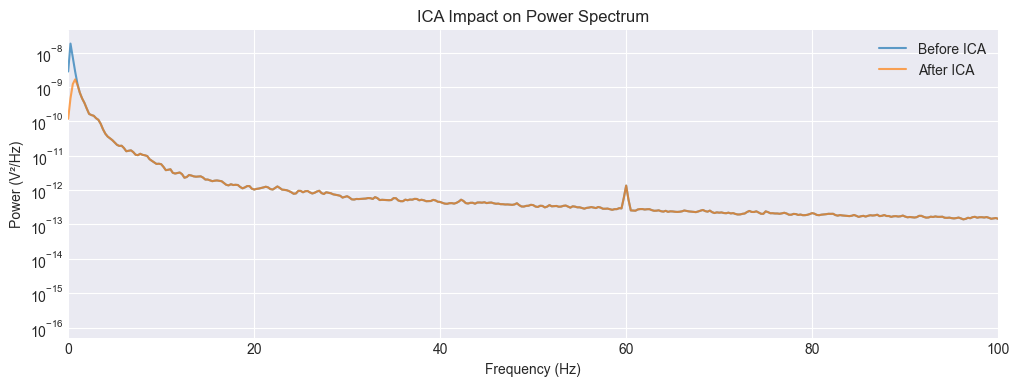

In [78]:
# Check what you're removing
print(f"ICA excluded components: {ica.exclude}")
print(f"Information content retained: {20/129*100:.1f}%")

# Visualize before/after
freqs_before, psd_before = welch(raw.get_data(), fs=sfreq, nperseg=int(sfreq*4), axis=1)
freqs_after, psd_after = welch(raw_asr.get_data(), fs=sfreq, nperseg=int(sfreq*4), axis=1)

plt.figure(figsize=(12, 4))
plt.semilogy(freqs_before, np.mean(psd_before, axis=0), label='Before ICA', alpha=0.7)
plt.semilogy(freqs_after, np.mean(psd_after, axis=0), label='After ICA', alpha=0.7)
plt.legend()
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power (V²/Hz)')
plt.title('ICA Impact on Power Spectrum')
plt.xlim([0, 100])

In [79]:
def remove_high_amplitude_noise(raw, amplitude_threshold_uv=150):
    '''
    Remove high amplitude noise from EEG data
    
    Parameters:
    - raw: MNE raw object
    - amplitude_threshold_uv: threshold in microvolts
    
    Returns:
    - raw_clean: cleaned raw object
    - n_bad_samples: number of bad samples removed
    '''
    data = raw.get_data()
    amplitude_threshold_v = amplitude_threshold_uv * 1e-6
    
    # Find samples exceeding threshold
    bad_samples = np.any(np.abs(data) > amplitude_threshold_v, axis=0)
    n_bad = np.sum(bad_samples)
    
    raw_clean = raw.copy()
    
    # Convert bad sample indices to time segments
    times = raw.times[bad_samples]
    
    if len(times) > 0:
        # Group consecutive bad samples into segments
        diff = np.diff(times)
        gap_threshold = 1.0 / raw.info['sfreq'] * 10
        
        onsets = [times[0]]
        durations = []
        
        for i, dt in enumerate(diff):
            if dt > gap_threshold:
                durations.append(times[i] - onsets[-1])
                onsets.append(times[i+1])
        
        # Add final segment
        if len(onsets) > len(durations):
            durations.append(times[-1] - onsets[-1])
        
        # Add annotations
        annot = mne.Annotations(onset=onsets, duration=durations, description=['bad_amplitude']*len(onsets))
        raw_clean.set_annotations(annot)
    
    print(f"High amplitude noise: Detected {n_bad} bad samples ({100*n_bad/len(bad_samples):.2f}%)")
    print(f"Amplitude threshold: {amplitude_threshold_uv} µV")
    
    return raw_clean, n_bad

In [80]:
raw_clean, n_bad_samples = remove_high_amplitude_noise(raw_epic, amplitude_threshold_uv=300)

High amplitude noise: Detected 22096 bad samples (25.64%)
Amplitude threshold: 300 µV


In [81]:
# Validation: Check power retention
freqs_before, psd_before = welch(raw.get_data(), fs=sfreq, nperseg=int(sfreq*4), axis=1)
power_before = np.mean(psd_before)

freqs_after, psd_after = welch(raw_clean.get_data(), fs=sfreq, nperseg=int(sfreq*4), axis=1)
power_after = np.mean(psd_after)

power_retained_pct = power_after / power_before * 100
print(f"\n⚠️ Power retained after cleaning: {power_retained_pct:.1f}%")
if power_retained_pct < 50:
    print("⚠️ WARNING: Aggressive filtering detected! Consider increasing thresholds.")


⚠️ Power retained after cleaning: 22.0%
⚠️ WARNING: Aggressive filtering detected! Consider increasing thresholds.


In [82]:
# Extract cleaned data
data_clean = raw_clean.get_data()

# Calculate raw power for each channel (mean square amplitude)
raw_power = np.mean(data_clean**2, axis=1)
raw_power_total = np.mean(raw_power)

# Calculate per-epoch power
window_size = int(5 * sfreq)  # 5-second windows
n_windows = data_clean.shape[1] // window_size

raw_power_temporal = []
for i in range(n_windows):
    start = i * window_size
    end = start + window_size
    window_power = np.mean(data_clean[:, start:end]**2)
    raw_power_temporal.append(window_power)

raw_power_temporal = np.array(raw_power_temporal)

print(f"\nRaw Power Analysis:")
print(f"Mean raw power (all channels): {raw_power_total:.2e} V²")
print(f"Power per channel range: {np.min(raw_power):.2e} - {np.max(raw_power):.2e} V²")



Raw Power Analysis:
Mean raw power (all channels): 2.18e-09 V²
Power per channel range: 0.00e+00 - 1.25e-07 V²


In [83]:
# Compute power spectral density using Welch's method
nperseg = int(sfreq * 4)  # 4-second windows
noverlap = int(sfreq * 2)  # 50% overlap

# FIX: Change 'sfreq' parameter to 'fs' for scipy.signal.welch
freqs, psd = welch(data_clean,
                    fs=sfreq,  # Changed from sfreq= to fs=
                    nperseg=nperseg,
                    noverlap=noverlap,
                    axis=1)

print(f"\nPSD computed: {psd.shape}")
print(f"Frequency range: {freqs[0]:.2f} - {freqs[-1]:.2f} Hz")

# Define frequency bands
bands = {
    'delta': (0.5, 4),
    'theta': (4, 8),
    'alpha': (8, 13),
    'beta': (13, 30),
    'gamma': (30, 100)
}

# Calculate global band power
print("\nGlobal band power (averaged across all channels):")
for band_name, (f_min, f_max) in bands.items():
    mask = (freqs >= f_min) & (freqs <= f_max)
    global_band_power = np.mean(psd[:, mask])
    print(f"{band_name:8s}: {global_band_power:.2e} V²/Hz")



PSD computed: (129, 1001)
Frequency range: 0.00 - 250.00 Hz

Global band power (averaged across all channels):
delta   : 4.42e-10 V²/Hz
theta   : 1.99e-11 V²/Hz
alpha   : 5.19e-12 V²/Hz
beta    : 1.28e-12 V²/Hz
gamma   : 3.01e-13 V²/Hz


In [86]:
# Diagnostic: Check actual signal statistics
print("\n=== EEG Data Statistics ===")
raw_data = raw.get_data()
print(f"95th percentile amplitude: {np.percentile(np.abs(raw_data), 95)*1e6:.2f} µV")
print(f"99th percentile amplitude: {np.percentile(np.abs(raw_data), 99)*1e6:.2f} µV")
print(f"99.9th percentile amplitude: {np.percentile(np.abs(raw_data), 99.9)*1e6:.2f} µV")
print(f"\nCurrent amplitude threshold: {300} µV")  # Your new threshold


=== EEG Data Statistics ===
95th percentile amplitude: 8159.02 µV
99th percentile amplitude: 193893.78 µV
99.9th percentile amplitude: 193893.78 µV

Current amplitude threshold: 300 µV


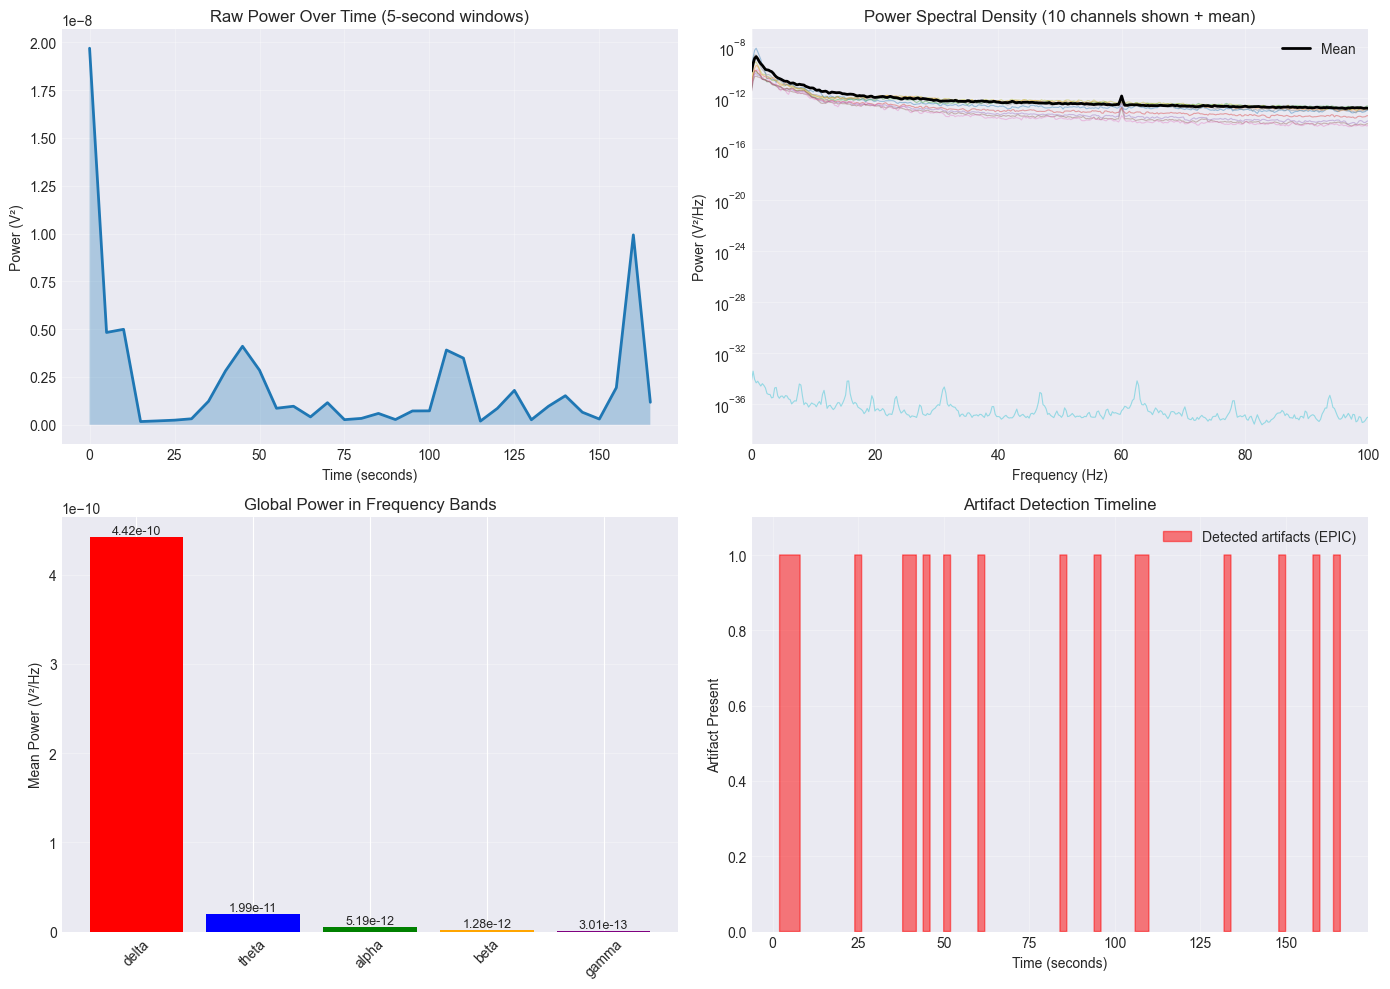

In [85]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

time_windows = np.arange(len(raw_power_temporal)) * 5
axes[0, 0].plot(time_windows, raw_power_temporal, linewidth=2)
axes[0, 0].fill_between(time_windows, raw_power_temporal, alpha=0.3)
axes[0, 0].set_xlabel('Time (seconds)')
axes[0, 0].set_ylabel('Power (V²)')
axes[0, 0].set_title('Raw Power Over Time (5-second windows)')
axes[0, 0].grid(True, alpha=0.3)

for i in range(min(10, psd.shape[0])):
    axes[0, 1].semilogy(freqs, psd[i, :], alpha=0.4, linewidth=0.8)

mean_psd = np.mean(psd, axis=0)
axes[0, 1].semilogy(freqs, mean_psd, color='black', linewidth=2, label='Mean')
axes[0, 1].set_xlabel('Frequency (Hz)')
axes[0, 1].set_ylabel('Power (V²/Hz)')
axes[0, 1].set_title('Power Spectral Density (10 channels shown + mean)')
axes[0, 1].grid(True, alpha=0.3, which='both')
axes[0, 1].legend()
axes[0, 1].set_xlim([0, 100])

band_names = list(bands.keys())
band_means = []

for b in band_names:
    mask = (freqs >= bands[b][0]) & (freqs <= bands[b][1])
    global_power = np.mean(psd[:, mask])
    band_means.append(global_power)

axes[1, 0].bar(band_names, band_means, color=['red', 'blue', 'green', 'orange', 'purple'])
axes[1, 0].set_ylabel('Mean Power (V²/Hz)')
axes[1, 0].set_title('Global Power in Frequency Bands')
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].grid(True, alpha=0.3, axis='y')

for i, (name, value) in enumerate(zip(band_names, band_means)):
    axes[1, 0].text(i, value, f'{value:.2e}', ha='center', va='bottom', fontsize=9)

time_seconds = np.arange(len(artifact_mask)) / sfreq
axes[1, 1].fill_between(time_seconds, 0, 1, where=artifact_mask, alpha=0.5, 
                         color='red', label='Detected artifacts (EPIC)', step='mid')
axes[1, 1].set_xlabel('Time (seconds)')
axes[1, 1].set_ylabel('Artifact Present')
axes[1, 1].set_title('Artifact Detection Timeline')
axes[1, 1].set_ylim([0, 1.1])
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

if time_seconds[-1] > 300:
    axes[1, 1].set_xlim([0, 300])

plt.tight_layout()
plt.show()